In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import gym
from collections import defaultdict
#from lib.envs import blackjack
matplotlib.style.use('ggplot')

#### Environment : Blackjack

Open AI gym documentation: https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py

In [0]:
env = gym.make('Blackjack-v0')

#### Action Space:

Two possible actions - Hit (1), Stick (0)

In [0]:
env.action_space

Discrete(2)

#### Observation space:

The observation is an environment specific object representing agent's observation of the environment. In the case of BlackJack, the observation is 3-tuple representing:
  1.  the players current sum
  2. the dealer's one showing card (1-10 where 1 is ace)
  3. whether or not the player holds a usable ace (0 or 1)

In [0]:
env.observation_space.spaces

(Discrete(32), Discrete(11), Discrete(2))

In [0]:
observation = env.reset()
print(observation)

(19, 4, False)


In [0]:
action = 0 # Stick 
observation, reward, done, info = env.step(action)
observation, reward, done, info

((19, 4, False), 1.0, True, {})

In [0]:
def display_observation(observation):
  player_score, dealer_score, usable_ace = observation
  print("Player score: {} , Usable_ace: {}, Dealer score: {}".format(player_score,usable_ace,dealer_score))

def policy(observation):
  player_score, dealer_score, usable_ace = observation
  
  if player_score >= 20:
    return 0   # Stick
  else:
    return 1   # Hit if score <17

If neither player nor dealer busts, the outcome (win, lose, draw) is decided by whose sum is closer to 21.  The reward for winning is +1, drawing is 0, and losing is -1.

In [0]:
def play_blackjack(num_episodes):
  for episode in range(num_episodes):
    observation= env.reset()
    for i in range(100):
      display_observation(observation)
      
      action = policy(observation)
      print("Action taken: {}".format(["Stick","Hit"][action]))
      
      observation, reward, done, info = env.step(action)
      if done:
        print("Final state:")
        display_observation(observation)
        print("Game ended with Reward : {}".format(reward))
        print("---------------------------------------------------------------")
        break

In [0]:
play_blackjack(10)

Player score: 5 , Usable_ace: False, Dealer score: 3
Action taken: Hit
Player score: 7 , Usable_ace: False, Dealer score: 3
Action taken: Hit
Player score: 16 , Usable_ace: False, Dealer score: 3
Action taken: Hit
Final state:
Player score: 23 , Usable_ace: False, Dealer score: 3
Game ended with Reward : -1
---------------------------------------------------------------
Player score: 14 , Usable_ace: False, Dealer score: 4
Action taken: Hit
Player score: 17 , Usable_ace: False, Dealer score: 4
Action taken: Hit
Player score: 21 , Usable_ace: False, Dealer score: 4
Action taken: Stick
Final state:
Player score: 21 , Usable_ace: False, Dealer score: 4
Game ended with Reward : 1.0
---------------------------------------------------------------
Player score: 13 , Usable_ace: False, Dealer score: 9
Action taken: Hit
Player score: 15 , Usable_ace: False, Dealer score: 9
Action taken: Hit
Final state:
Player score: 25 , Usable_ace: False, Dealer score: 9
Game ended with Reward : -1
----------

#### Monte Carlo State Value Estimation 

In [0]:
def estimate_state_value_function(env, policy, num_episodes, discount=1.0):

  returns_sum = defaultdict(float)
  returns_count = defaultdict(float)

  V = defaultdict(float)

  for episode in range(1, num_episodes+1):

      episodes = []
      state = env.reset()
      for t in range(100):
          action = policy(state)
          next_state, reward, end, _ = env.step(action)
          episodes.append((state, action, reward))
          if end:
              break
          state = next_state
          
      states_in_episode = [tup[0] for tup in episodes]
      for state in states_in_episode:
          first_occurence_idx = next(i for i,x in enumerate(episodes) if x[0] == state)
          
          G = sum([x[2]*(discount**i) for i,x in enumerate(episodes[first_occurence_idx:])])
          
          # Calculate average return for this state over all sampled episodes
          returns_sum[state] += G
          returns_count[state] += 1.0
          V[state] = returns_sum[state] / returns_count[state]
    
  return V


In [0]:
final_V_10k = estimate_state_value_function(env, policy, 10000)
final_V_50k = estimate_state_value_function(env, policy, 500000)

####Plotting the value function - taken from : https://github.com/dennybritz/reinforcement-learning/blob/master/lib/plotting.py

In [0]:
import matplotlib
import numpy as np
import pandas as pd
from collections import namedtuple
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

def plot_cost_to_go_mountain_car(env, estimator, num_tiles=20):
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
    X, Y = np.meshgrid(x, y)
    Z = np.apply_along_axis(lambda _: -np.max(estimator.predict(_)), 2, np.dstack([X, Y]))

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                           cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Value')
    ax.set_title("Mountain \"Cost To Go\" Function")
    fig.colorbar(surf)
    plt.show()


def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))



def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    if noshow:
        plt.close(fig3)
    else:
        plt.show(fig3)

    return fig1, fig2, fig3

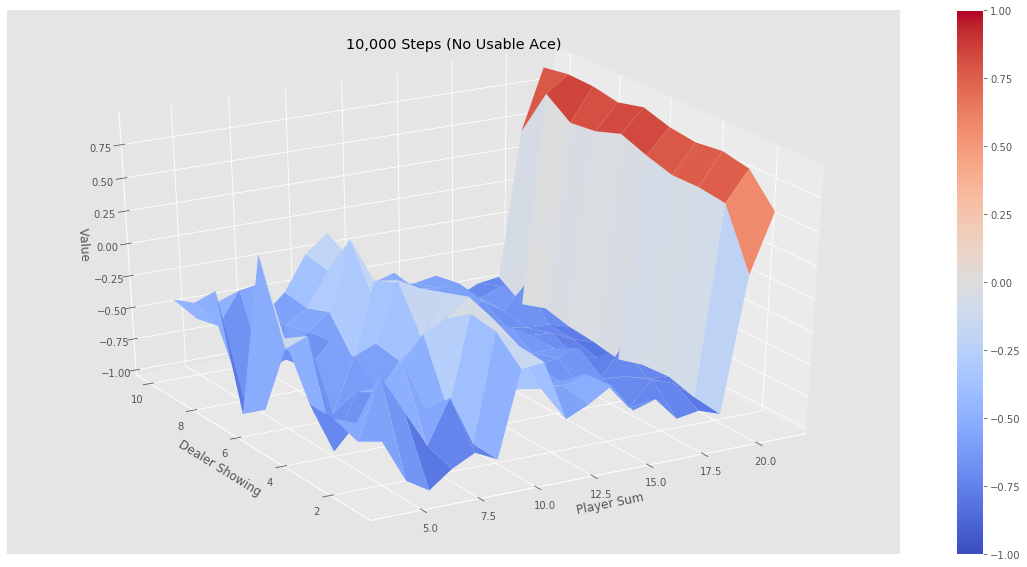

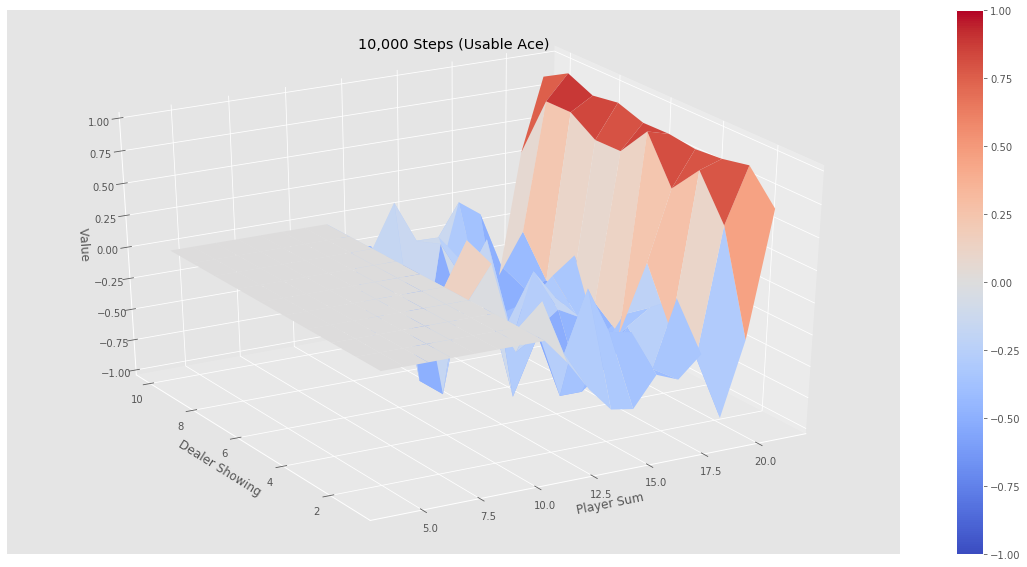

In [0]:
plot_value_function(final_V_10k, title="10,000 Steps")

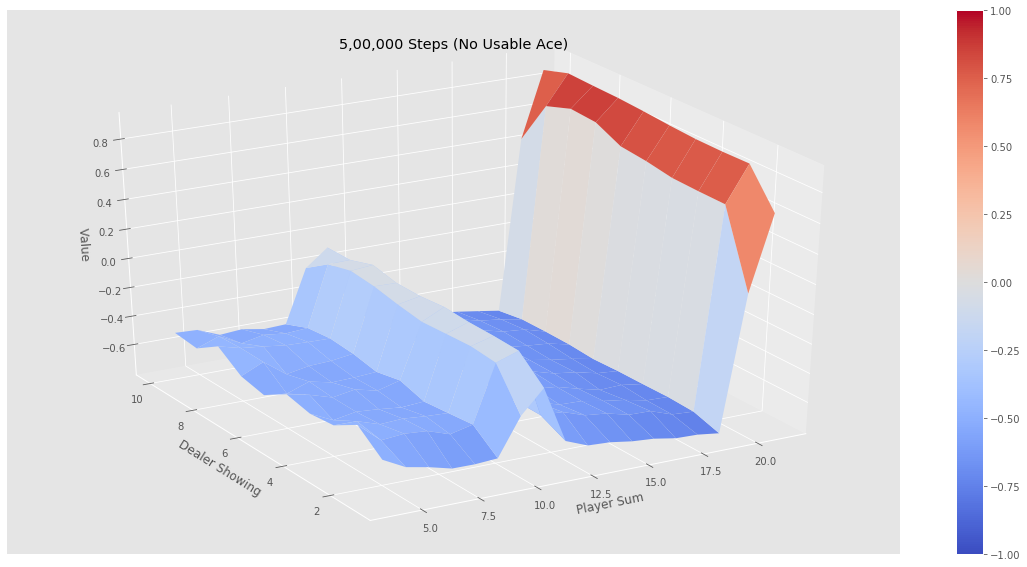

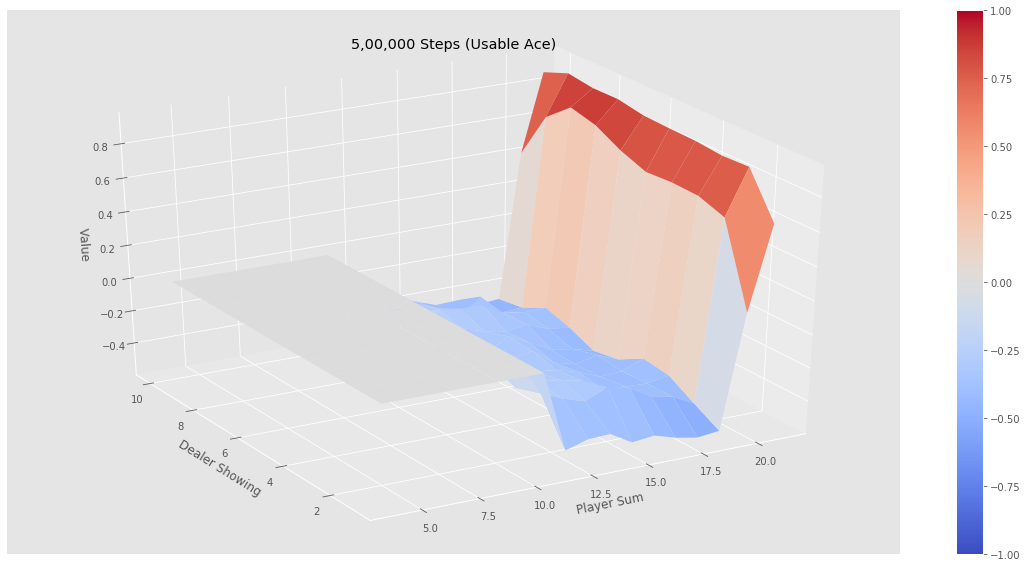

In [0]:
plot_value_function(final_V_50k, title="5,00,000 Steps")

Our implementation uses some part of the software under the following license:

1. MIT License (Denny Britz)
2. MIT License (Open AI)

MIT License

Copyright (c) 2016 Denny Britz

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

The MIT License

Copyright (c) 2016 OpenAI (https://openai.com)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.